<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/itsystems/neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd

#https://github.com/nerush/aind2-rnn/blob/master/RNN_project.ipynb

In [290]:
numerator = [1]
denominator = [1, 1]
deltaTime = 0.01
discrete = signal.cont2discrete((numerator, denominator), deltaTime)
print(discrete)

(array([[0.        , 0.00995017]]), array([ 1.        , -0.99004983]), 0.01)


In [0]:
def connect(*F):
  def connected(g):
    result = g
    for f in F:
      result = f(result)
    return result
  return connected

$\frac{Y(s)}{U(s)}=\frac{K}{Ts+1}$

$Y(s) \cdot (Ts+1)=U(s) \cdot K$

$Ty'(t)+y(t)=Ku(t)$

$y'(t)+\frac{1}{T}y(t)=\frac{K}{T}u(t)$

$y'(t)=\frac{K}{T}u(t)-\frac{1}{T}y(t)$

Euler:

$\lim\limits_{dt \to 0} \frac{y(t+dt)-y(t)}{dt} =\frac{K}{T}u(t)-\frac{1}{T}y(t)$

$\frac{y(t+dt)-y(t)}{dt} =\frac{K}{T}u(t)-\frac{1}{T}y(t)$

$y(t+dt)-y(t) =dt \left( \frac{K}{T}u(t)-\frac{1}{T}y(t) \right)$

$y(t+dt) =y(t) + dt \left( \frac{K}{T}u(t)-\frac{1}{T}y(t) \right)$

In [0]:
def createFilter1Order(K, T, deltaTime, y0 = 0):
  k1 = K / T
  k2 = 1 / T
  def filter(u):
    currentState = y0
    for time, value in u:
      result = currentState + deltaTime * (k1 * value - k2 * currentState)
      currentState = result
      yield (time, result)
  return filter

$\frac{Y(s)}{U(s)}=\frac{Ts+1}{As^2+Bs+1}$

$Ay''(t)+By'(t)+y(t)=Tu'(t)+u(t)$

$Ay''(t)=Tu'(t)+u(t)-By'(t)-y(t)$

$Ay''(t)=Tu'(t)-By'(t)+u(t)-y(t)$

$y''(t)=\frac{T}{A}u'(t)-\frac{B}{A}y'(t)+\frac{1}{A}u(t)-\frac{1}{A}y(t)$

$y(t)=x_1(t)$

$x'_1(t)=\frac{T}{A}u(t)-\frac{B}{A}x_1(t) + x_2(t)$

$x'_2(t)=\frac{1}{A}u(t)-\frac{1}{A}x_1(t)$



In [0]:
def createFilter2Order(T, A, B, deltaTime, x10 = 0, x20 = 0):
  def filter(u):
    x1 = x10
    x2 = x20
    for time, value in u:
      nx1 = x1 + deltaTime *((T / A) * value - B / A * x1 + x2)
      nx2 = x2 + deltaTime * ((1 / A) * value - 1 / A * x1)
      yield (time, nx1)
      x1 = nx1
      x2 = nx2
  return filter

In [0]:
def createTimeGenerator(endTime, startTime = 0, deltaTime = 0.01):
  def time():
    currentTime = startTime
    while True:
      yield (currentTime, currentTime)
      currentTime = currentTime + deltaTime
      if currentTime > endTime:
        break
  return time

In [0]:
def createStep(stepTime):
  def u(gen):
    for (time, value) in gen:
      if (time < stepTime):
        yield (time, 0)
      else:
        yield (time, 1)
  return u

In [0]:
from random import random as rnd
from random import seed
def createRandomSignal(startValue, stepValue):
  def u(gen):
    currentValue = startValue
    for (time, value) in gen:
      r = 2 * rnd() - 1
      yield time, stepValue * r
  return u


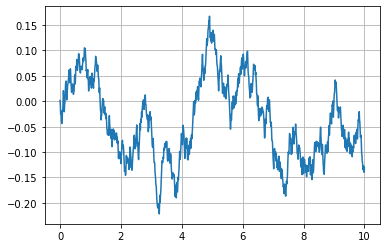

In [297]:
deltaTime = 0.01
endTime = 20

system = connect(
#    createStep(stepTime = 1),
    createRandomSignal(10, 1),
    createFilter1Order(2, 1, deltaTime)
)

timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = 10)
output = system(timeFunc())
t = []
y = []
cnt = 1000
#print(next(timeFunc()))
seed(30)
for time, value in output:
  t.append(time)
  y.append(value)

plt.plot(t, y)
plt.grid(which='both')

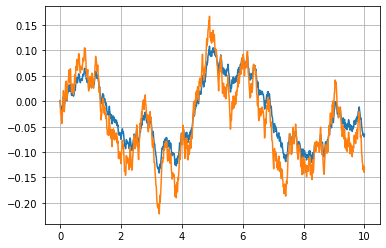

In [298]:
system2 = connect(
#    system,
    createRandomSignal(10, 1),
    createFilter2Order(1, 1, 1, deltaTime = deltaTime)
)
timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = 10)
output2 = system2(timeFunc())
t2 = []
y2 = []
seed(30)
tx = list(timeFunc())
for time, value in output2:
  t2.append(time)
  y2.append(value)
plt.plot(t2, y2, t, y)
plt.grid(which='both')


In [0]:
def createWindowFunc(windowSize = 10):
  def windowFunc(gen):
    bufferT = []
    bufferV = []
    for time, value in gen:
      if len(bufferT) == windowSize:
        yield (*bufferT, time, *bufferV, value)
      bufferT.append(time)
      bufferV.append(value)
      if len(bufferT) > windowSize:
        bufferT.pop(0)
        bufferV.pop(0)
  return windowFunc

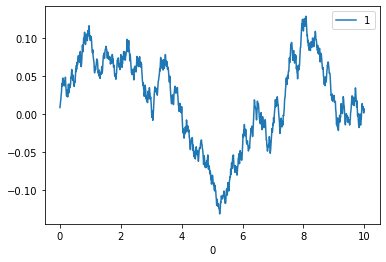

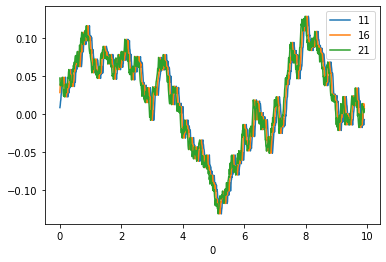

In [300]:
system2 = connect(
#    system,
    createRandomSignal(10, 1),
    createFilter2Order(1, 1, 1, deltaTime = deltaTime)
)
timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = 10)
output2 = list(system2(timeFunc()))
seed(30)
df = pd.DataFrame(output2)
df.plot.line(x=0, y=1)
window = createWindowFunc()
output3 = window(output2)
df3 = pd.DataFrame(output3)
df3.plot.line(x=0,y=[11,16,21])

In [307]:
import numpy as np

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


# and window-size into a set of input/output pairs for use with our RNN model
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = [series[i:i + window_size] for i in range(len(series) - window_size)]
    y = series[window_size:]

    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y), 1)

    return X, y


# TODO: build an RNN to perform regression on our time series input/output data
def build_part1_RNN(window_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=5, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(units=1))
    return model

windowSize = 10
output2a = list(map(lambda item: item[0], output2))
print(output2a)
#print(window_transform_series(output2a, windowSize))
model = build_part1_RNN(windowSize)

[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09, 0.09999999999999999, 0.10999999999999999, 0.11999999999999998, 0.12999999999999998, 0.13999999999999999, 0.15, 0.16, 0.17, 0.18000000000000002, 0.19000000000000003, 0.20000000000000004, 0.21000000000000005, 0.22000000000000006, 0.23000000000000007, 0.24000000000000007, 0.25000000000000006, 0.26000000000000006, 0.2700000000000001, 0.2800000000000001, 0.2900000000000001, 0.3000000000000001, 0.3100000000000001, 0.3200000000000001, 0.3300000000000001, 0.34000000000000014, 0.35000000000000014, 0.36000000000000015, 0.37000000000000016, 0.38000000000000017, 0.3900000000000002, 0.4000000000000002, 0.4100000000000002, 0.4200000000000002, 0.4300000000000002, 0.4400000000000002, 0.45000000000000023, 0.46000000000000024, 0.47000000000000025, 0.48000000000000026, 0.49000000000000027, 0.5000000000000002, 0.5100000000000002, 0.5200000000000002, 0.5300000000000002, 0.5400000000000003, 0.5500000000000003, 0.5600000000000003, 0.57